In [1]:
# Mount google drive to access image files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import libraries
import numpy as np
import pandas as pd
import os
import pathlib
import hashlib
import PIL
import PIL.Image as Image
from fastai.vision.all import *
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

In [3]:
# List physical devices and check if any GPUs are available and if required enable memory growth
physical_devices = tf.config.list_physical_devices('GPU')

if physical_devices:
    try:
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        print("Memory growth enabled for GPU:", physical_devices[0])
    except RuntimeError as e:
        print(e)
else:
    print("No GPU found.")

Memory growth enabled for GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [4]:
print(tf.__version__)

2.17.0


In [5]:
# Specify directory to retrieve images
data_dir = pathlib.Path('/content/drive/MyDrive/Nebulae')
data_folder = pathlib.Path('/content/drive/MyDrive/NewData')


In [6]:
# Specify seed value
seed_value = 123
random.seed(seed_value)
tf.random.set_seed(seed_value)
np.random.seed(seed_value)

In [7]:
# Specify parameters for loading dataset
# batch_size = 128
img_size = 224

In [8]:
# Shuffle, preprocess and load data
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  labels='inferred',
  label_mode='int',
  color_mode='rgb',
  # batch_size=batch_size,
  image_size=(img_size, img_size),
  shuffle=True,
  seed=seed_value,
  validation_split=0.30,
  subset='both'
)

# Split data into train and validation
ds_train, ds_validation = ds

Found 10119 files belonging to 5 classes.
Using 7084 files for training.
Using 3035 files for validation.


In [9]:
# Split data into validation and test sets
val_batches = tf.data.experimental.cardinality(ds_validation)

# Convert val_batches to a Python integer before multiplication
test_ds = ds_validation.take(int(val_batches.numpy() * 0.4))
val_ds = ds_validation.skip(int(val_batches.numpy() * 0.4))

print(f"Number of training batches: {tf.data.experimental.cardinality(ds_train)}")
print(f"Number of validation batches: {tf.data.experimental.cardinality(val_ds)}")
print(f"Number of test batches: {tf.data.experimental.cardinality(test_ds)}")

Number of training batches: 222
Number of validation batches: 57
Number of test batches: 38


In [10]:
# Instantiate model
model = Sequential()

# Use EfficientNetB0 as pre-trained model
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(img_size, img_size, 3), # Input img_size and channels
    include_top=False, # Unfreeze dense layers
    weights='imagenet', # Use imagenet weights
    pooling='max' # Use max pooling
)

pretrained_model.trainable = False

# Build layers starting with pre_trained model, then flatten to one-dimensional vector, then dense layers
model.add(pretrained_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.4)),
model.add(layers.Dense(256, activation='relu')),
model.add(layers.Dropout(0.4)),
model.add(layers.Dense(128, activation='relu')),
model.add(layers.Dropout(0.4)),
model.add(layers.Dense(64, activation='relu')),
model.add(layers.Dropout(0.4)),
model.add(layers.Dense(5)) # Specify 5 neural nodes given that there are 5 classes

# Compile model using 'adam' as optimiser, sparse categorical cross entropy and accuracy as metrics
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Define early_stopping with a patience of 10
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
%%time

# Set up the log directory for TensorBoard
log_dir = os.path.join(data_folder, "logs", "fit", "run_" + str(int(time.time())))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Continue with model training using ds_train
history = model.fit(ds_train,
                    shuffle = True,
                    # batch_size=batch_size, # Not used here given it will reduce performance
                    # steps_per_epoch = 70, # Not used here given it will reduce performance
                    epochs=100, # Specify number of epochs as 100
                    validation_data=val_ds, # Validation using val_ds
                    callbacks=[early_stopping, tensorboard_callback]) # Specify callbacks


Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 275s 1s/step - accuracy: 0.2799 - loss: 2.3944 - val_accuracy: 0.5201 - val_loss: 1.2158
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - accuracy: 0.4834 - loss: 1.2629 - val_accuracy: 0.6745 - val_loss: 0.9814
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 166ms/step - accuracy: 0.5707 - loss: 1.1210 - val_accuracy: 0.7163 - val_loss: 0.8526
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.6483 - loss: 0.9829 - val_accuracy: 0.7317 - val_loss: 0.7773
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.6674 - loss: 0.9199 - val_accuracy: 0.7455 - val_loss: 0.7734
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.6878 - loss: 0.8959 - val_accuracy: 0.7680 - val_loss: 0.7228
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.7208 - loss: 0.8363 - val_accuracy: 0.7647 - val_loss: 0.6967
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 37s 165ms/step - accuracy: 0.7251 - l

In [12]:
# Review model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)          │ (None, 1280)                │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,535,604 (24.93 MB)

 Trainable params: 828,677 (3.16 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

 Optimizer params: 1,657,356 (6.32 MB)

In [13]:
# Evaluate model
loss, accuracy = model.evaluate(val_ds)
print("Validation Loss:", loss)
print("Validation Accuracy:", accuracy)

# Obtain predictions for the validation dataset for further analysis
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.8337 - loss: 0.5656
Validation Loss: 0.5526440739631653
Validation Accuracy: 0.833424985408783
57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 195ms/step


Train and validation accuracy scores are very close indicating that the model is not over or under fitted

In [14]:
# Extract actual labels from val_ds
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)

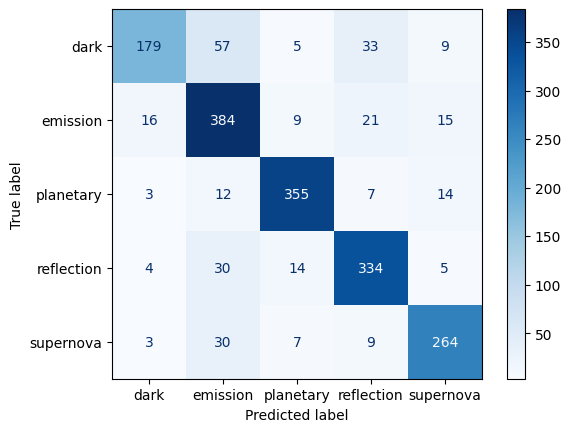

In [15]:
# Create confusion matrix for val_ds
cm = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix
labels = ds_train.class_names
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig(data_folder / 'confusion_matrix_b0.png')
plt.show()

Noting here that nebulae are mostly misclassified as emission nebula

In [16]:
# Create classification report
report = classification_report(y_true, y_pred_classes, target_names=labels, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print(report_df)

              precision    recall  f1-score      support
dark           0.873171  0.632509  0.733607   283.000000
emission       0.748538  0.862921  0.801670   445.000000
planetary      0.910256  0.907928  0.909091   391.000000
reflection     0.826733  0.863049  0.844501   387.000000
supernova      0.859935  0.843450  0.851613   313.000000
accuracy       0.833425  0.833425  0.833425     0.833425
macro avg      0.843727  0.821972  0.828096  1819.000000
weighted avg   0.838495  0.833425  0.831877  1819.000000


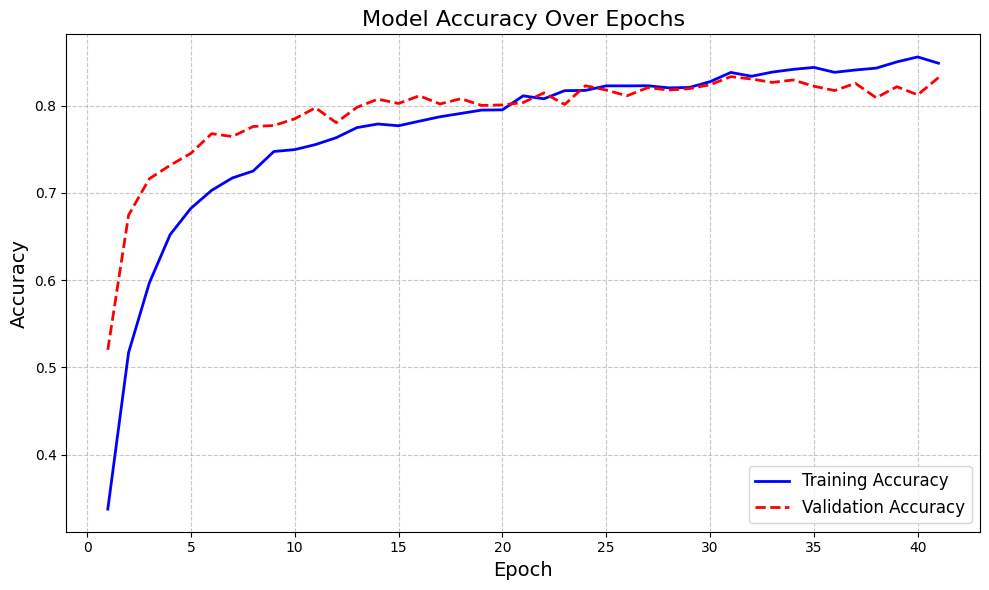

In [17]:
# Plot accuracy scores for the model
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'],
         label='Training Accuracy', color='blue', linestyle='-', linewidth=2)
plt.plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'],
         label='Validation Accuracy', color='red', linestyle='--', linewidth=2)

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=16)
plt.legend(loc='lower right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(data_folder / 'accuracy_plot_b0.png')
plt.show()

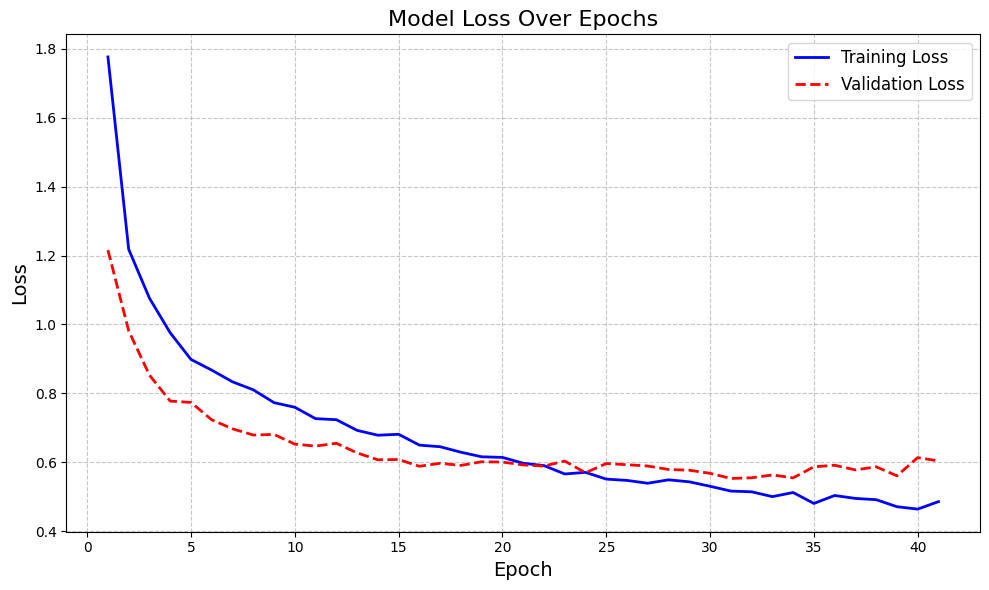

In [18]:
# Plot training and validation loss for the model
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'],
         label='Training Loss', color='blue', linestyle='-', linewidth=2)
plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'],
         label='Validation Loss', color='red', linestyle='--', linewidth=2)

plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Model Loss Over Epochs', fontsize=16)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(data_folder / 'loss_plot_b0.png')
plt.show()

In [19]:
# Evaluate model using test scores
loss2, accuracy2 = model.evaluate(test_ds)
print("Test Loss:", loss2)
print("Test Accuracy:", accuracy2)

# Obtain predictions for the validation dataset for further analysis
y_pred_test = model.predict(test_ds)
y_pred_classes_test = np.argmax(y_pred_test, axis=1)

38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.8033 - loss: 0.6358
Test Loss: 0.5952849388122559
Test Accuracy: 0.8149670958518982
38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step


In [20]:
# Extract actual labels from test_ds
y_true_test = np.concatenate([y.numpy() for x, y in test_ds], axis=0)

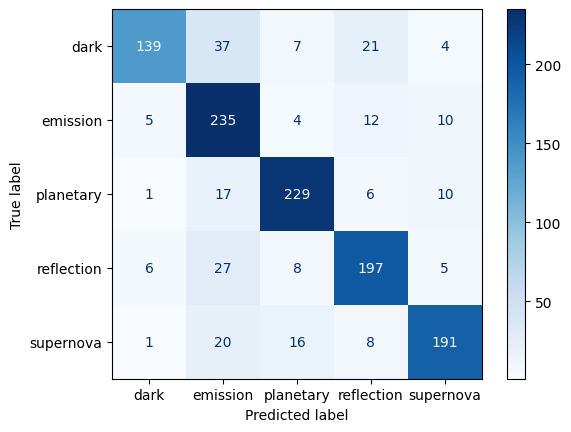

In [21]:
# Create confusion matrix
cm_test = confusion_matrix(y_true_test, y_pred_classes_test)

labels = ds_train.class_names
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=labels)
disp.plot(cmap=plt.cm.Blues)
plt.savefig(data_folder / 'confusion_matrix_b0_test.png')
plt.show()

In [22]:
# Create classification report
report_test = classification_report(y_true_test, y_pred_classes_test, target_names=labels, output_dict=True)
report_df_test = pd.DataFrame(report_test).transpose()

print(report_df_test)

              precision    recall  f1-score      support
dark           0.914474  0.668269  0.772222   208.000000
emission       0.699405  0.883459  0.780731   266.000000
planetary      0.867424  0.870722  0.869070   263.000000
reflection     0.807377  0.810700  0.809035   243.000000
supernova      0.868182  0.809322  0.837719   236.000000
accuracy       0.814967  0.814967  0.814967     0.814967
macro avg      0.831372  0.808494  0.813756  1216.000000
weighted avg   0.826865  0.814967  0.815098  1216.000000


In [23]:
# Save the model
model.save(data_folder / 'EfficientNetB0-Imagenet_maxpool_0.4do.keras')

In [24]:
import pickle

# Save the history object to a file
with open(data_folder / 'training_history_b0.pkl', 'wb') as file:
    pickle.dump(history.history, file)

In [25]:
# Save history as a dataframe
history_df = pd.DataFrame(history.history)
history_df.to_csv(data_folder / 'training_historyb0.csv', index=False)